<a href="https://colab.research.google.com/github/Haebuk/dataminingTP/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re

In [50]:
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumGothic Eco


## Data Load

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
test_df = pd.read_csv(PATH + 'test_df_regex.csv')
o_train_df = pd.read_csv(PATH + 'train.csv')

- exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)
- transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)
- transaction_year_month: 거래년월
- transaction_date: 거래일
- floor: 층 

- 데이터가 거래시간 순으로 이루어져 있음

### regex preprocessing
- apt 이름에 존재하는 괄호 + 괄호안 내용 제거

In [53]:
# 괄호와 괄호안내용 제거
#regex = "\(.*\)|\s-\s.*"
#for i in tqdm(range(len(train_df)), position=0, leave=True):
#    train_df['apt'][i] = re.sub(regex, '', train_df['apt'][i])

#train_df.to_csv('train_df_regex.csv', index=False)


In [54]:
# 괄호와 괄호안내용 제거
#regex = "\(.*\)|\s-\s.*"
#for j in tqdm(range(len(test_df)),position=0, leave=True):
#    test_df['apt'][i] = re.sub(regex, '', test_df['apt'][i])
    
#test_df.to_csv('test_df_regex.csv', index=False)

## Preprocessing
### Train and Test set

In [55]:
train_df.describe() 

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1215092 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- train_df 결측치는 없음
- 1961년 ~ 2017년 완공 건물
- 9.26m^2 ~ 424.32m^2 전용면적
- Floor의 경우 음의 값 존재.
- 실거래가는 100만원부터 820억까지 존재

In [57]:
train_df.loc[train_df['transaction_real_price']==820000]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


In [58]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [59]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 512.3+ KB


### apart

In [60]:
train_df['apt'].value_counts()

현대         17716
한신         10135
삼성          6771
대우          6390
신동아         6386
           ...  
동문타운           1
대림빌라트          1
래미안에스티움        1
장수             1
체리빌            1
Name: apt, Length: 9373, dtype: int64

In [61]:
# 같은 아파트 이름을 같는 수를 저장하는 apt_counts 열 생성
train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test_df['apt_counts'] = 0
test_df.groupby('apt')['apt_counts'].count()
test_df = pd.merge(test_df, test_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13.0
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1.0
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13.0


In [62]:
train_df.shape

(1216553, 14)

In [76]:
train_df['apt'].value_counts()[:10]

현대            81824
주공            65937
래미안           32743
한신            27481
벽산            26968
우성            24524
롯데캐슬          24053
삼성            20067
sk|SK|에스케이    19709
두산            19501
Name: apt, dtype: int64

- top10 시공사 + 데이터에서 가장 많이 나오는 아파트 20개의 이름을 통일

In [64]:
train_df['top10'] = 0
test_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1
    test_df.loc[test_df['apt'].str.contains(brand), 'top10'] = 1


# top30에 해당하는 아파트가 아니면서 200채가 안될 경우 others로 변경
#train_df.loc[(train_df['top30']==0) & (train_df['apt_counts'] < 200), 'apt'] = 'others'
#test_df.loc[(test_df['top30']==0) & (test_df['apt_counts'] < 200), 'apt'] = 'others'

In [65]:
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
apt_names = top10 + apt_names
for a in apt_names:
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test_df.loc[test_df['apt'].str.contains(a), 'apt'] = a

In [68]:
train_df.groupby(['dong', 'apt'])['apt_counts'].agg('count')[60:100]

dong  apt         
가락동   현진타워              1
가리봉동  미래하이츠             5
      효성               54
가산동   others            0
      가산양우내안에애플        76
      가산지웰에스테이트        90
      덕산               28
      두산              694
      드림캐슬             16
      드림케슬3차            8
      백운한비치            16
      비즈트위트바이올렛5차     135
      삼익              112
      온누리              24
      원평5차              8
      해찬행복드림           10
가야동   가야삼정그린코아        257
      가야삼한사랑채         111
      국민               82
      금수하이빌            12
      다산몽레브            10
      더휴인5차             3
      동아               46
      동원              144
      동원로얄듀크           93
      마마               23
      반도그린빌             3
      반도보라빌           678
      벽산              780
      보광               20
      삼우               15
      새영진              43
      수옥빌               8
      시영              213
      영림로즈빌             7
      영진               44
      유림              149
      이편한|e편한|e-편한 

In [75]:
train_df.loc[train_df['dong']=='한남동', 'apt'].unique()

array(['한성1', '아일랜드캐슬', '한남동리첸시아', '뉴캐슬하우스', '리버탑', '태성1', '힐탑트레져1동',
       '리버티하우스', '힐스테이트', '시범', '성아1', '현대', '장미1', '대림', '효성빌리지',
       '오페라하우스3차', '대성 이태리하우스', '스카이빌2', '한남하우스', '형우베스트빌3차', '남산맨션',
       '한남로얄팰리스', '오페라하우스WEST', '로얄튼빌라', '트윈빌 비동', '트윈빌 에이동', '한남동동원베네스트',
       '신성미소시티', '한남파라곤', 'others', '한남더힐', '아울스스퀘어', '윌쏘나슈트',
       '한남동UNVILLAGE루하우스', '한남해피트리', '아이파크'], dtype=object)

In [ ]:
len(train_df[train_df['apt']=='힐하우스'])

6

In [ ]:
train_df['apt'].value_counts()

others       232855
10            81994
16            65937
7             35322
11            27481
              ...  
자유1             202
신괴정화신아파트        202
수락리버시티3단지       202
목련타운            200
대광              200
Name: apt, Length: 768, dtype: int64

In [ ]:
len(top30)

30

In [ ]:
print(train_df['apt'].nunique(),test_df['apt'].nunique())

768 31


In [ ]:
test_df

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,apt_counts,top30
0,1145756,10453,서울특별시,목동,938,others,목동 938 청학,35.5500,2002,201711,11~20,2,1,False
1,1198704,989,부산광역시,초량동,1143-8,others,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2,1,False
2,1222384,8597,부산광역시,괴정동,447-13,others,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2,1,False
3,1179897,11086,서울특별시,대치동,1007-2,others,대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10,2,False
4,1223091,2121,부산광역시,다대동,1670,3,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,1174640,8965,서울특별시,양재동,15-9,others,양재동 15-9 위너스,84.0500,2003,201710,11~20,7,1,False
5459,1175575,3831,서울특별시,반포동,18-1,7,반포동 18-1 래미안퍼스티지,84.9300,2009,201712,1~10,4,2,True
5460,1157024,5550,서울특별시,구로동,256-1,7,구로동 256-1 삼성래미안,110.1880,2004,201712,21~31,23,23,True
5461,1136863,3371,서울특별시,홍제동,24-16,others,홍제동 24-16 동양드림,92.4400,2005,201710,21~31,1,1,False


In [ ]:
all_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [ ]:
# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
all_df['year_of_completion'] = all_df['year_of_completion'] - all_df['year_of_completion'].min()
# 거래연월에서 최소연월을 뺌으로써 거래연월 라벨 인코딩
all_df['transaction_year_month'] -= all_df['transaction_year_month'].min()
# 필요없는 열 제거
all_df = all_df.drop(['jibun', 'transaction_date', 'addr_kr', 'apt_counts', 'top30'], axis=1)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
0,0,7622,서울특별시,신교동,others,84.82,41,0,2,37500.0


### dong

In [ ]:
seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set # 부산광역시와 서울특별시에는 부암동, 사직동, 송정동, 중동 4가지의 이름이 같은 동이 존재함
print(same_dong)

{'중동', '부암동', '송정동', '사직동'}


- 서울과 부산에 중동, 부암동, 송정동, 사직동이 겹침을 알 수 있음

In [ ]:
for d in same_dong:
    all_df.loc[(all_df['city']=='서울특별시') & (all_df['dong']==d), 'dong'] = '서울' + d
    all_df.loc[(all_df['city']=='부산광역시') & (all_df['dong']==d), 'dong'] = '부산' + d

seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

set()


- 더 이상 겹치는 동이 없음

In [ ]:
train_df.loc[train_df['dong'].str.contains('장충동')].groupby('dong')['transaction_real_price'].\
agg('mean')

dong
장충동1가    269888.888889
장충동2가      6628.421053
Name: transaction_real_price, dtype: float64

- 같은 동이어도 숫자가 다르면 가격차이가 많이 남
- 따라서 따로 숫자처리를 진행하지 않고 다른 동처럼 취급

In [ ]:
dong_price = train_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:10]

dong
장충동1가     269888.888889
압구정동      164534.722914
청암동       161403.700000
용산동5가     153497.331633
회현동2가     139906.140351
반포동       132489.395651
한남동       122593.293264
서빙고동      116547.239777
대치동       116320.538909
남대문로5가    113153.604651
Name: transaction_real_price, dtype: float64

- 동별로 그룹화 후 가격의 평균 계산
- 가격의 평균의 내림차 순으로 정렬

In [ ]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행
for i, d in enumerate(list(dong_price.index)):
    all_df.loc[all_df['dong'] == d, 'dong'] = i
all_df.head()

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
0,0,7622,서울특별시,137,others,84.82,41,0,2,37500.0
1,1,5399,서울특별시,64,others,99.17,12,0,6,20000.0
2,2,3578,서울특별시,64,others,84.74,46,0,6,38500.0
3,3,10957,서울특별시,13,others,146.39,42,0,15,118000.0
4,4,10639,서울특별시,13,others,194.43,43,0,3,120000.0


#### Price

findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.


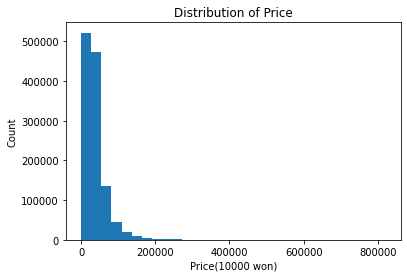

In [ ]:
# train price
plt.figure()
plt.hist(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.ylabel('Count')
plt.title('Distribution of Price')
plt.show()

- 가격의 분포가 매우 왼쪽으로 치우친 것을 확인할 수 있음
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있음
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환

In [ ]:
# 가격 로그 변환 후 원래 가격 따로 저장
all_df['log_price'] = np.log1p(all_df['transaction_real_price'])
real_price = all_df['transaction_real_price'] # 원래 가격
train_y = real_price[:train_df.shape[0]] # train 데이터의 가격
test_y = real_price[train_df.shape[0]:] # test 데이터의 가격
all_df.drop('transaction_real_price', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,log_price
0,0,7622,서울특별시,신교동,others,84.82,41,0,2,10.532123


### Area

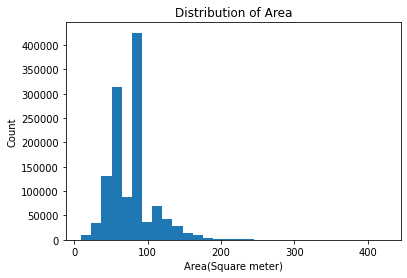

In [ ]:
# train area
plt.figure()
plt.hist(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.ylabel('Count')
plt.title('Distribution of Area')
plt.show()

In [ ]:
# 면적 로그 변환 후 원래 가격 따로 저장
all_df['log_area'] = np.log1p(all_df['exclusive_use_area'])
area = all_df['exclusive_use_area'] # 원래 가격
all_df.drop('exclusive_use_area', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,log_price,log_area
0,0,7622,서울특별시,신교동,others,41,0,2,10.532123,4.452252


### Encoding

In [ ]:
def label_encoder(col):
    le = LabelEncoder()
    return le.fit_transform(col)
ohe_col = ['city', 'dong']
label_col = ['apt']
drop_col = ['transaction_id', 'apartment_id', 'city', 'dong', 'apt']

ohe_columns = pd.get_dummies(all_df[ohe_col])
le_columns = all_df[label_col].apply(label_encoder)


In [ ]:
all_df = pd.concat([all_df.drop(drop_col, axis=1), ohe_columns, le_columns], axis=1)
all_df.head()

,year_of_completion,transaction_year_month,floor,log_price,log_area,city_부산광역시,city_서울특별시,dong_가락동,dong_가리봉동,dong_가산동,dong_가야동,dong_가양동,dong_갈월동,dong_갈현동,dong_감만동,dong_감전동,dong_감천동,dong_강일동,dong_개금동,dong_개봉동,dong_개포동,dong_거여동,dong_거제동,dong_견지동,dong_고덕동,dong_고척동,dong_공덕동,dong_공릉동,dong_공항동,dong_광안동,dong_광장동,dong_괘법동,dong_괴정동,dong_교남동,dong_교북동,dong_구기동,dong_구로동,dong_구산동,dong_구서동,dong_구수동,...,dong_풍납동,dong_필동1가,dong_필동3가,dong_필운동,dong_하계동,dong_하단동,dong_하왕십리동,dong_하월곡동,dong_하중동,dong_학장동,dong_한강로1가,dong_한강로2가,dong_한강로3가,dong_한남동,dong_합동,dong_합정동,dong_항동,dong_행당동,dong_행촌동,dong_현석동,dong_현저동,dong_혜화동,dong_홍은동,dong_홍익동,dong_홍제동,dong_화곡동,dong_화명동,dong_화양동,dong_황학동,dong_회기동,dong_회동동,dong_회현동1가,dong_회현동2가,dong_효제동,dong_효창동,dong_후암동,dong_휘경동,dong_흑석동,dong_흥인동,apt
0,41,0,2,10.532123,4.452252,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39
1,12,0,6,9.903538,4.606869,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39
2,46,0,6,10.558439,4.451319,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39
3,42,0,15,11.678448,4.993082,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39
4,43,0,3,11.695255,5.275202,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39


In [ ]:
all_df.shape

(1222016, 481)

In [ ]:
train_df = all_df[:train_df.shape[0]]
test_df = all_df[train_df.shape[0]:].drop('log_price', axis=1)

## Modeling

In [ ]:
NFOLDS = 5

def rmsle_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train_df.values, train_y, scoring='neg_mean_squared_error'))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=1))
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

#### Area

- 면적도 마찬가지로 정규화

#### What is Underground Floor ?

In [ ]:
under_floor = train_df.loc[train_df['floor']<0]
print(f'총 {under_floor.shape[0]}개의 음수 층 있음')
print(under_floor['floor'].value_counts())

- 168개의 지하층이 존재함

In [ ]:
plt.figure()
sns.countplot(under_floor['floor'])
plt.title('')
plt.show()

In [ ]:
under_floor[['floor', 'transaction_real_price']].corr()

층수와 가격간의 선형 설명력이 어느정도 존재하기 때문에 제거하지 않는다.

In [ ]:
test_df.head()

In [ ]:
test_df.describe()

In [ ]:
test_df.info()

- test셋에도 널값은 존재하지 않음.
- 실거래가 변수 없음(타겟 변수)
- 완공연도 1961년부터 2017년
- 실거래연도는 2017년도만 존재함
- 전용면적은 10.32m^2부터 273.86m^2까지 존재

In [ ]:
plt.figure(figsize=(8, 8))
sns.countplot(test_df['transaction_year_month'])
plt.xticks(rotation=60)
plt.show()

2017년 데이터만 존재하며, 12월 데이터가 가장 많음

- 시설에 매우 많은 결측치가 존재함
- 시설이 존재하면 1 없으면 0으로 값 대체


- 분포가 매우 왼쪽으로 치우친 형태
- 공원 면적이 집 값에 영향을 미치는가?